## IMPORT NECCESSARY LIBRARY

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity 
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import umap.umap_ as umap


2025-12-25 14:58:33.307264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766674713.475418      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766674713.524957      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766674713.924164      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766674713.924207      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766674713.924210      24 computation_placer.cc:177] computation placer alr

## LOAD DATAFRAME

In [2]:
df_anime = pd.read_csv('/kaggle/input/anime-recomendation/data_anime (1).csv')
df_rating = pd.read_csv('/kaggle/input/anime-recomendation/data_rating (1).csv')

## NECCESSARY FUNCTION

### 1. NDCG@K , precision@K , map@K

In [3]:

def ndcg_at_k(y_true, y_pred, k):
    """
    y_true: list hoặc set item relevant
    y_pred: list item được rank (giảm dần theo score)
    """
    if len(y_true) == 0:
        return 0.0

    y_true = set(y_true)
    y_pred_k = y_pred[:k]

    # DCG
    dcg = 0.0
    for i, item in enumerate(y_pred_k):
        if item in y_true:
            dcg += 1.0 / np.log2(i + 2)

    # IDCG
    ideal_hits = min(len(y_true), k)
    idcg = sum(1.0 / np.log2(i + 2) for i in range(ideal_hits))

    return dcg / idcg if idcg > 0 else 0.0



In [4]:
def precision_at_k(y_true, y_pred, k):
    top_k = y_pred[:k]
    hit = len(set(top_k) & set(y_true))

    return hit / k if k > 0 else 0.0


In [5]:
def average_precision_at_k(y_true, y_pred, k):
    if len(y_true) == 0:
        return 0.0

    score = 0.0
    hits = 0
    y_true = set(y_true)

    for i, item in enumerate(y_pred[:k], start=1):
        if item in y_true:
            hits += 1
            score += hits / i

    return score / min(len(y_true), k)



### 2. cluster feature content

In [6]:
def cluster_metrics(X_emb):
    X_emb = np.array(X_emb)
    kmeans = KMeans(n_clusters=20)
    labels = kmeans.fit_predict(X_emb)

    metrics = {
        "silhouette_score": silhouette_score(X_emb, labels),
        "calinski_harabasz": calinski_harabasz_score(X_emb, labels),
        "davies_bouldin": davies_bouldin_score(X_emb, labels)
    }

    return metrics

### 3. visualization for feature content

In [7]:
def visualize_embeddings_2D(df_embedding, title_prefix = "Embedding"):

    X = np.vstack(df_embedding["embedding"].values)

    #  PCA Visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(7, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, s=10)
    plt.title(f"{title_prefix} - PCA 2D")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(alpha=0.3)
    plt.show()

    print("→ PCA explained variance ratio:", pca.explained_variance_ratio_)

    #  UMAP Visualization 
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
    X_umap = reducer.fit_transform(X)

    plt.figure(figsize=(7, 6))
    plt.scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.6, s=10)
    plt.title(f"{title_prefix} - UMAP 2D")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.grid(alpha=0.3)
    plt.show()

    print("Visualization complete.")



In [8]:
def visualize_embeddings_3D(df_embedding, title_prefix="Embeddings"):
    X = np.vstack(df_embedding["embedding"].values)


    # PCA 3D
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)

    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection="3d")

    ax.scatter(
        X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
        s=12, alpha=0.65
    )
    ax.set_title(f"{title_prefix} - PCA 3D")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")

    plt.show()

    print("→ PCA explained variance ratio:", pca.explained_variance_ratio_)

    #  UMAP 3D
    reducer = umap.UMAP(
        n_neighbors=15,
        min_dist=0.1,
        n_components=3,
        metric="cosine"
    )
    X_umap = reducer.fit_transform(X)

    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection="3d")

    ax.scatter(
        X_umap[:, 0], X_umap[:, 1], X_umap[:, 2],
        s=12, alpha=0.65
    )
    ax.set_title(f"{title_prefix} - UMAP 3D")
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_zlabel("UMAP-3")

    plt.show()

    print("Visualization 3D complete.")


### 4. build item content and recommend_topK similarity

In [9]:
def build_user_content(df_rating, item_embeddings):
    # tạo map từ anime_id → embedding
    emb_map = dict(zip(item_embeddings['anime_id'], item_embeddings['embedding']))

    user_rows = []

    for user_id, g in df_rating.groupby('user_id'):
        user_items = g['anime_id'].tolist()
        user_ratings = g['rating'].tolist()

        # lấy embedding cho các item user đã xem
        vectors = []
        for item, rating in zip(user_items, user_ratings):
            if item in emb_map:
                vectors.append(emb_map[item] * max(rating - 7, 0))  # weighted

        if len(vectors) == 0:
            continue

        # weighted average
        user_vec = np.mean(vectors, axis=0)

        user_rows.append({
            'user_id': user_id,
            'embedding': user_vec
        })

    return pd.DataFrame(user_rows)


In [10]:
def recommend_topk_similarity(user_id, df_rating, df_content_user, df_item_embeddings, k=10):

    # ---- Lấy user vector ----
    user_vec = df_content_user.loc[df_content_user['user_id'] == user_id, 'embedding'].values[0]

    # ---- Lấy danh sách item user đã tương tác ----
    user_items = df_rating[df_rating['user_id'] == user_id]['anime_id'].unique()

    # Nếu user chưa có item nào → trả rỗng
    if len(user_items) == 0:
        return []

    # ---- Lọc embedding chỉ giữ item user có tương tác ----
    filtered_df = df_item_embeddings[df_item_embeddings['anime_id'].isin(user_items)]

    item_ids  = filtered_df['anime_id'].values
    item_vecs = np.vstack(filtered_df['embedding'].values)

    # ---- Tính cosine similarity ----
    scores = cosine_similarity([user_vec], item_vecs)[0]

    # ---- Lấy top-K ----
    top_idx = np.argsort(-scores)[:k]
    return item_ids[top_idx]

    

In [11]:
def evaluate_content_based_topk(
    df_rating,
    user_content_eval,
    test_items_df,
    recommend_fn,
    k=10,
    rating_threshold=7
):

    # ---- Prepare test item set
    test_item_set = set(test_items_df['anime_id'].unique())

    # ---- Ground truth: user -> set(item)
    user_gt = (
        df_rating[
            (df_rating['rating'] >= rating_threshold) &
            (df_rating['anime_id'].isin(test_item_set))
        ]
        .groupby('user_id')['anime_id']
        .apply(set)
        .to_dict()
    )

    # ---- Users to evaluate
    users_id = user_content_eval['user_id'].unique()

    total_ndcg = 0.0
    total_precision = 0.0
    total_map = 0.0
    count = 0

    for user_id in users_id:
        if user_id not in user_gt:
            continue

        label = user_gt[user_id]
        if len(label) < k:
            continue

        pred = recommend_fn(
            user_id,
            df_rating,
            user_content_eval,
            test_items_df,
            k=k
        )

        if len(pred) < k:
            continue

        count += 1
        total_ndcg += ndcg_at_k(label, pred, k)
        total_precision += precision_at_k(label, pred, k)
        total_map += average_precision_at_k(label, pred, k)

    if count == 0:
        return {"NDCG": 0, "Precision": 0, "MAP": 0}

    return {
        f"NDCG@{k}": total_ndcg / count,
        f"Precision@{k}": total_precision / count,
        f"MAP@{k}": total_map / count
    }


### CONTENT-BASED METHOD

### 1. Content-based with Genres-feature

**One-hot encoding**

In [12]:
df_content_genres = df_anime[['anime_id', 'Genres']]
df_content_genres['genres_list'] = df_content_genres['Genres'].apply(lambda x: x.split(", "))

/tmp/ipykernel_24/4150122441.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_content_genres['genres_list'] = df_content_genres['Genres'].apply(lambda x: x.split(", "))


In [13]:
mlb = MultiLabelBinarizer()
multi_hot = mlb.fit_transform(df_content_genres['genres_list'])

**Learning latent embedding via VAE**

In [14]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)
        self.fc_out = nn.Linear(64, input_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h2 = self.relu(self.fc2(z))
        return self.sigmoid(self.fc_out(h2))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD



Epoch 0, Loss: 301010.5625
Epoch 50, Loss: 157746.4375
Epoch 100, Loss: 122349.0781
Epoch 150, Loss: 112830.1875
Epoch 200, Loss: 108207.1719
Epoch 250, Loss: 106736.2422
Epoch 300, Loss: 105719.6250
Epoch 350, Loss: 104752.2969
Epoch 400, Loss: 104191.3203
Epoch 450, Loss: 103775.0469
Epoch 500, Loss: 103233.4453
Epoch 550, Loss: 102693.3281
Epoch 600, Loss: 102088.1797
Epoch 650, Loss: 101870.8828
Epoch 700, Loss: 101130.1250
Epoch 750, Loss: 100403.0781
Epoch 800, Loss: 99651.8984
Epoch 850, Loss: 99399.5703
Epoch 900, Loss: 98600.5938
Epoch 950, Loss: 98168.9219
Epoch 1000, Loss: 97986.8125
Epoch 1050, Loss: 97618.1562
Epoch 1100, Loss: 97297.4375
Epoch 1150, Loss: 97344.3594
Epoch 1200, Loss: 97202.8906
Epoch 1250, Loss: 96872.5781
Epoch 1300, Loss: 96714.5312
Epoch 1350, Loss: 96128.6875
Epoch 1400, Loss: 95945.2500
Epoch 1450, Loss: 95851.3125
Epoch 1500, Loss: 95625.8281
Epoch 1550, Loss: 95496.1172
Epoch 1600, Loss: 95147.4375
Epoch 1650, Loss: 95143.3438
Epoch 1700, Loss: 953

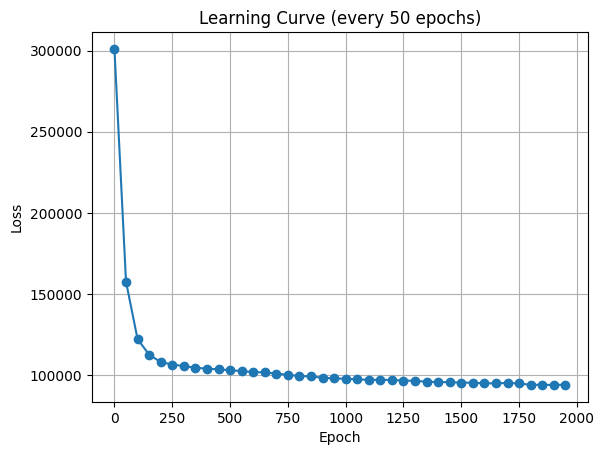

In [ ]:
X_tensor = torch.FloatTensor(multi_hot)  # shape: (num_items, num_genres)

input_dim = multi_hot.shape[1]
latent_dim = 32
batch_size = 64
vae = VAE(input_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
num_epochs = 2000

log = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    recon, mu, logvar = vae(X_tensor)
    loss = vae_loss(recon, X_tensor, mu, logvar)
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
        log.append(loss.item())

epochs = [50 * (i) for i in range(len(log))]

plt.figure()
plt.plot(epochs, log, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve (every 50 epochs)")
plt.grid(True)
plt.show()


In [16]:
# final extract embedding content item 
with torch.no_grad():
    mu, logvar = vae.encode(X_tensor)
    item_genres_embeddings = mu
item_genres_embeddings = item_genres_embeddings.detach().cpu().numpy()
print(item_genres_embeddings.shape)  # (num_items, latent_dim)

(10639, 32)


In [17]:
# build genres content 
genres_content = pd.DataFrame({
    "anime_id": df_content_genres["anime_id"].values,
    "embedding": list(item_genres_embeddings)  # mỗi hàng là 1 vector numpy
})


In [18]:
genres_content.to_csv('content-based-item.csv')

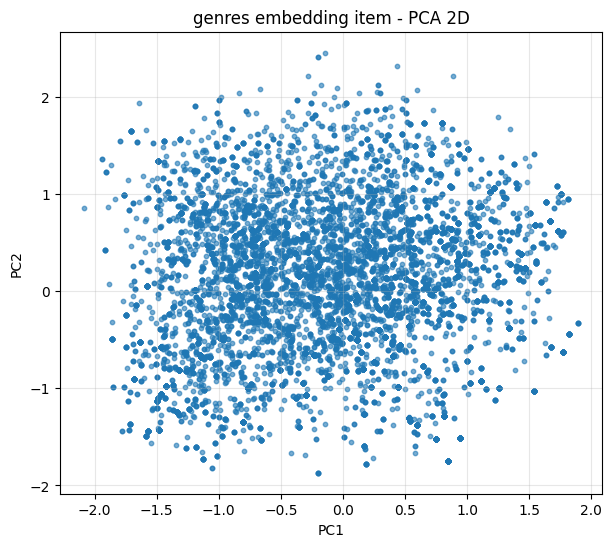

→ PCA explained variance ratio: [0.22232822 0.19339842]


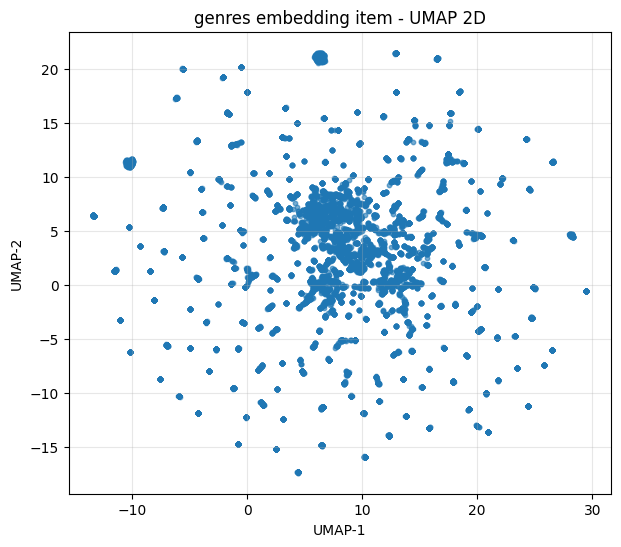

Visualization complete.


In [19]:
import matplotlib.pyplot as plt
# visualization the embedding genres feature of item in 2D
visualize_embeddings_2D(genres_content, "genres embedding item") 

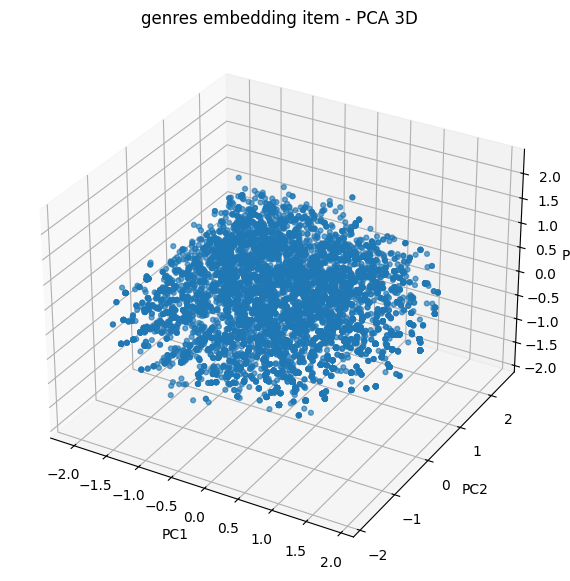

→ PCA explained variance ratio: [0.22232822 0.19339842 0.15856338]


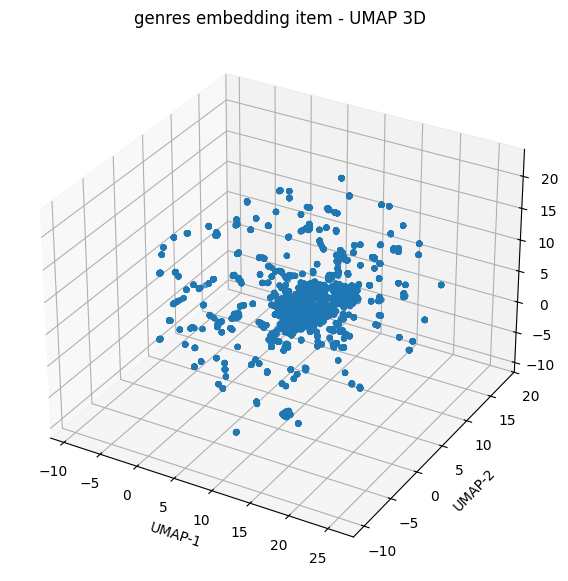

Visualization 3D complete.


In [20]:
# visualization the embedding genres features of item in 3D
visualize_embeddings_3D(genres_content, "genres embedding item")

**Evaluation**

In [21]:
user_content_genres = build_user_content(df_rating, genres_content)

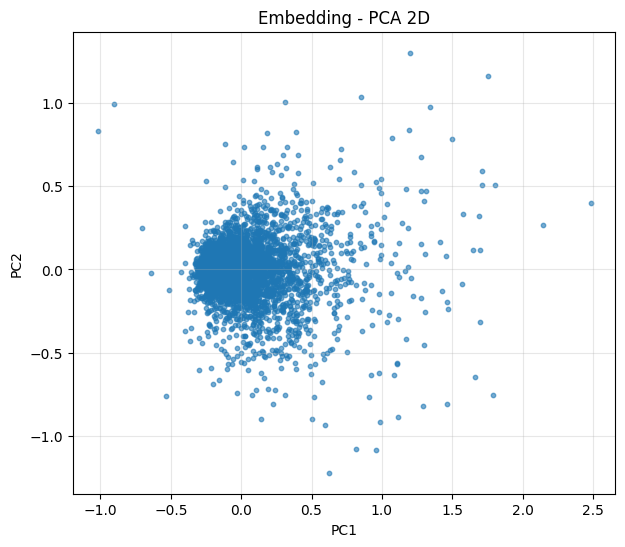

→ PCA explained variance ratio: [0.55917627 0.21368872]


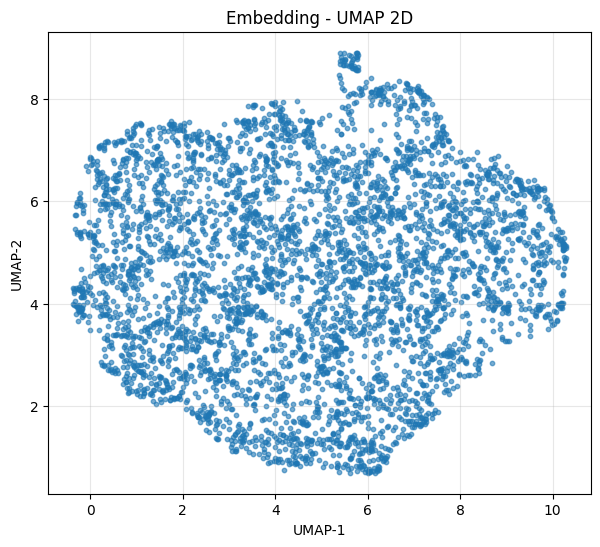

Visualization complete.


In [22]:
visualize_embeddings_2D(user_content_genres)

In [23]:
# Evaluation similarity top K recommendation of content-based 

# train-test split build user content 
train_genres, test_genres = train_test_split(genres_content, test_size = 0.4, random_state = 42)
user_content_genres_eval = build_user_content(df_rating, test_genres)


for k in [10,20,40]:
    res = evaluate_content_based_topk(
        df_rating=df_rating,
        user_content_eval=user_content_genres_eval,
        test_items_df=test_genres,
        recommend_fn=recommend_topk_similarity,
        k=k,
        rating_threshold=7
    )
    
    print(res)



{'NDCG@10': np.float64(0.7944315975688482), 'Precision@10': 0.7928828019757641, 'MAP@10': 0.7007517408999264}
{'NDCG@20': np.float64(0.7877381869745121), 'Precision@20': 0.7841159290047133, 'MAP@20': 0.6749064130886426}
{'NDCG@40': np.float64(0.7798232635359963), 'Precision@40': 0.7746231721034844, 'MAP@40': 0.653310780816654}


**Inference**

In [24]:
def recommend_topk(user_id, df_content_user, df_item_embeddings, k=10):

    # ---- Lấy user vector ----
    user_vec = df_content_user.loc[df_content_user['user_id'] == user_id, 'embedding'].values[0]

    item_ids  = df_item_embeddings['anime_id'].values
    item_vecs = np.vstack(df_item_embeddings['embedding'].values)

    # ---- Tính cosine similarity ----
    scores = cosine_similarity([user_vec], item_vecs)[0]

    # ---- Lấy top-K ----
    top_idx = np.argsort(-scores)[:k]
    return item_ids[top_idx]

    

In [25]:
user_id = 326
top_anime = recommend_topk(user_id, user_content_genres, genres_content, 10)
print(df_anime[df_anime['anime_id'].isin(top_anime)][['anime_id','Score','Genres','Name']])
print(df_rating[(df_rating['user_id'] == user_id) & (df_rating['anime_id'].isin)(top_anime)])

      anime_id  Score                                             Genres  \
2250      2683   7.27  Action, Mystery, Horror, Drama, Martial Arts, ...   
3833      6624   7.60    Action, Mystery, Romance, Super Power, Thriller   
6950     26243   7.49  Action, Military, Supernatural, Drama, Vampire...   
7154     28927   7.64  Action, Military, Supernatural, Drama, Vampire...   
7592     31147   6.71  Action, Demons, Drama, Fantasy, Mystery, Sci-F...   
7654     31378   7.17  Action, Military, Supernatural, Drama, Vampire...   
7918     32313   7.05  Action, Sci-Fi, Mystery, Super Power, Demons, ...   
8230     33248   7.37           Action, Super Power, Supernatural, Drama   
8234     33263   7.82               Action, Mystery, Supernatural, Drama   
9809     38536   6.82  Action, Mystery, Super Power, Psychological, S...   

                                                   Name  
2250       Tokyo Majin Gakuen Kenpucho: Tou Dai Ni Maku  
3833      Kara no Kyoukai Remix: Gate of Sevent

### 2. Content-based with text-feature

In [26]:
!pip install sentence-transformers

**Embedding feature in sentence-bert**

In [27]:
from sentence_transformers import SentenceTransformer 
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer('all-MiniLM-L6-v2', device = device )

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [28]:
# build genres content without finetune 
# item encode 
item_embeddings_pre = model.encode(
    df_anime.sypnopsis.tolist(),
    normalize_embeddings=True
)

synopsis_content_pre = pd.DataFrame({
    "anime_id": df_anime["anime_id"].values,
    "embedding": [np.array(item) for item in item_embeddings_pre.tolist()]  # mỗi hàng là 1 vector numpy
})


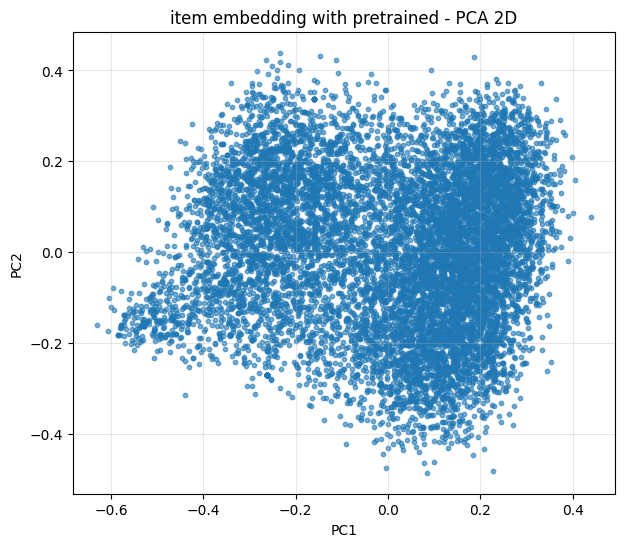

→ PCA explained variance ratio: [0.0587789  0.03665971]


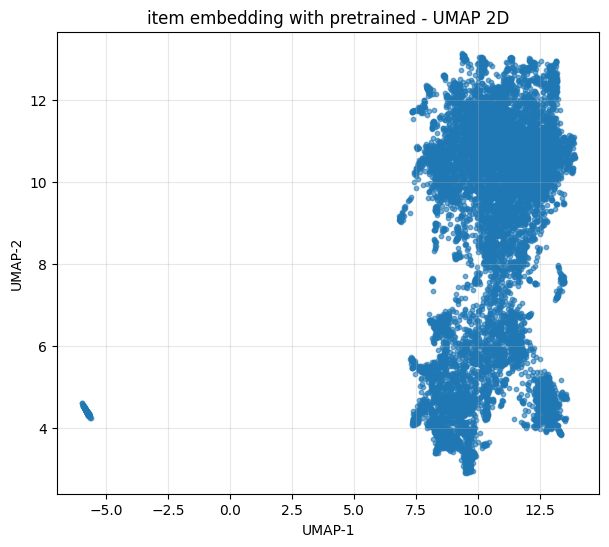

Visualization complete.


In [29]:
visualize_embeddings_2D(synopsis_content_pre, "item embedding with pretrained")

In [30]:
df_interaction = pd.merge(df_rating, df_anime[['anime_id','sypnopsis']], on = 'anime_id', how = 'inner')

In [31]:
df_interaction.head()

,user_id,anime_id,rating,sypnopsis
0,326,11061,9,Hunter x Hunter is set in a world where Hunter...
1,326,136,9,Hunters are specialized in a wide variety of f...
2,326,10408,8,"Intrigued by the tale of a mountain god, six-y..."
3,326,256,8,"It is the year 2046, Noboru Terao and Mikako N..."
4,326,11005,8,The story centers around a timid orphan named ...


In [32]:
df_interaction_finetune = df_interaction[:10000]

In [33]:
def build_user_text(df, user_id):
    pos = df[(df.user_id == user_id) & (df.rating >= 9)]
    return " ".join(pos.sypnopsis.tolist())


In [34]:
import sentence_transformers
from sentence_transformers import InputExample, losses
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm 

train_examples = []
for user_id in df_interaction_finetune.user_id.unique():
    user_text = build_user_text(df_interaction_finetune, user_id)
    if not user_text:
        continue
    positives = df_interaction_finetune[(df_interaction_finetune.user_id == user_id) & (df_interaction_finetune.rating >= 4)]
    for _, row in positives.iterrows():
        train_examples.append(
            InputExample(texts=[user_text, row.sypnopsis])
        )

In [35]:

train_loader = DataLoader(train_examples,
                          batch_size= 64, 
                          shuffle=True,
                         collate_fn = model.smart_batching_collate)
loss_fn = losses.MultipleNegativesRankingLoss(model)

In [36]:
print(len(train_loader))

144


In [37]:
for batch in train_loader:
    print(batch)
    if True:
        break 

([{'input_ids': tensor([[  101,  4477,  1060,  ...,  1010,  2108,   102],
        [  101,  2048,  4651,  ...,  8915, 12676,   102],
        [  101, 10848,  4689,  ..., 11895,  6182,   102],
        ...,
        [  101,  2028,  3147,  ..., 20305,  2040,   102],
        [  101,  2048,  4651,  ...,  8915, 12676,   102],
        [  101,  2048,  4651,  ...,  8915, 12676,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])}, {'input_ids': tensor([[  101, 22564,  9711,  ...,     0,     0,     0],
        [  101,  7632,  7677,  ...,     0,     0,     0],
        [  101, 

In [38]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
epochs = 50
model.train()

log = []
for epoch in range(epochs):
    total_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()

        features ,  labels= batch 
        features = [{k: v.to(device) for k, v in feat.items()} for feat in features]
        loss = loss_fn(features, labels)
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    log.append(total_loss/len(train_loader))

    print(f"Epoch {epoch+1} avg loss: {total_loss/len(train_loader):.4f}")


Epoch 1:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 1 avg loss: 4.2670


Epoch 2:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 2 avg loss: 3.9941


Epoch 3:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 3 avg loss: 3.9534


Epoch 4:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 4 avg loss: 3.9195


Epoch 5:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 5 avg loss: 3.8858


Epoch 6:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 6 avg loss: 3.8570


Epoch 7:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 7 avg loss: 3.8134


Epoch 8:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 8 avg loss: 3.7762


Epoch 9:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 9 avg loss: 3.7394


Epoch 10:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 10 avg loss: 3.7009


Epoch 11:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 11 avg loss: 3.6570


Epoch 12:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 12 avg loss: 3.6266


Epoch 13:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 13 avg loss: 3.5922


Epoch 14:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 14 avg loss: 3.5658


Epoch 15:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 15 avg loss: 3.5388


Epoch 16:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 16 avg loss: 3.5126


Epoch 17:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 17 avg loss: 3.4870


Epoch 18:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 18 avg loss: 3.4725


Epoch 19:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 19 avg loss: 3.4568


Epoch 20:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 20 avg loss: 3.4413


Epoch 21:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 21 avg loss: 3.4334


Epoch 22:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 22 avg loss: 3.4134


Epoch 23:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 23 avg loss: 3.4025


Epoch 24:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 24 avg loss: 3.3970


Epoch 25:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 25 avg loss: 3.3829


Epoch 26:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 26 avg loss: 3.3827


Epoch 27:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 27 avg loss: 3.3661


Epoch 28:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 28 avg loss: 3.3597


Epoch 29:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 29 avg loss: 3.3555


Epoch 30:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 30 avg loss: 3.3497


Epoch 31:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 31 avg loss: 3.3455


Epoch 32:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 32 avg loss: 3.3349


Epoch 33:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 33 avg loss: 3.3344


Epoch 34:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 34 avg loss: 3.3278


Epoch 35:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 35 avg loss: 3.3250


Epoch 36:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 36 avg loss: 3.3196


Epoch 37:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 37 avg loss: 3.3211


Epoch 38:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 38 avg loss: 3.3124


Epoch 39:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 39 avg loss: 3.3157


Epoch 40:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 40 avg loss: 3.3065


Epoch 41:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 41 avg loss: 3.3058


Epoch 42:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 42 avg loss: 3.3085


Epoch 43:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 43 avg loss: 3.2991


Epoch 44:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 44 avg loss: 3.2957


Epoch 45:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 45 avg loss: 3.2987


Epoch 46:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 46 avg loss: 3.2934


Epoch 47:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 47 avg loss: 3.2867


Epoch 48:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 48 avg loss: 3.2852


Epoch 49:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 49 avg loss: 3.2889


Epoch 50:   0%|          | 0/144 [00:00<?, ?it/s]

Epoch 50 avg loss: 3.2949


In [39]:
model.save("finetinue-sentencebert.pt")

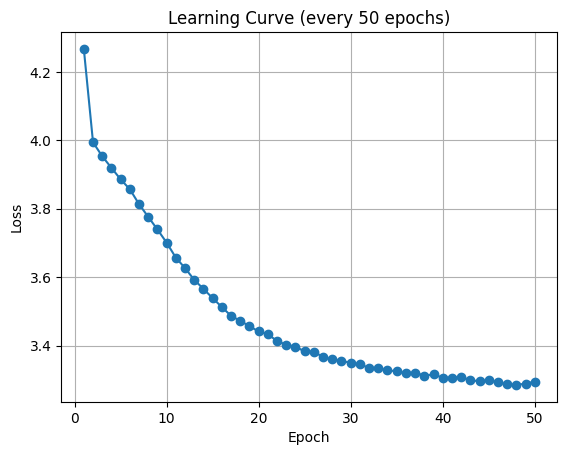

In [40]:

plt.figure()
plt.plot(range(1, epochs+1), log, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve (every 50 epochs)")
plt.grid(True)
plt.show()

In [41]:
# item encode 
item_embeddings = model.encode(
    df_anime.sypnopsis.tolist(),
    normalize_embeddings=True
)



In [42]:
# build genres content 
synopsis_content = pd.DataFrame({
    "anime_id": df_anime["anime_id"].values,
    "embedding": [np.array(item) for item in item_embeddings.tolist()]  # mỗi hàng là 1 vector numpy
})


In [43]:
synopsis_content.head()

,anime_id,embedding
0,1,"[-0.13341091573238373, 0.018770752474665642, -..."
1,5,"[-0.09181022644042969, 0.03422284498810768, 0...."
2,6,"[-0.08243687450885773, 0.04229753091931343, -0..."
3,7,"[-0.11940273642539978, 0.03666706010699272, 0...."
4,8,"[-0.08970534801483154, 0.0783686488866806, -0...."


**Evaluation Method**    

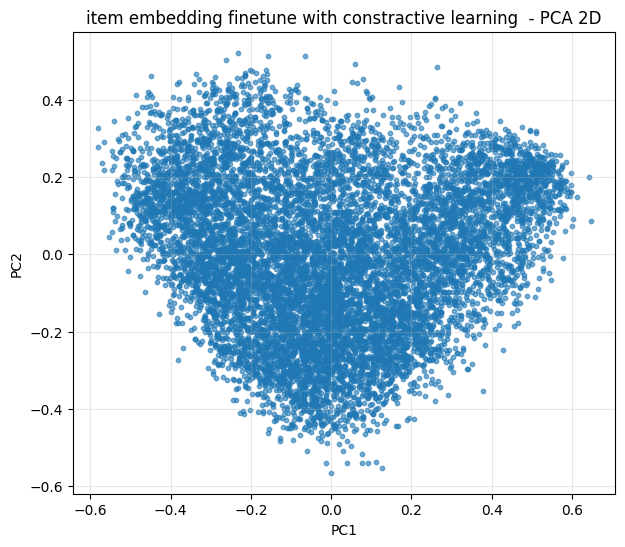

→ PCA explained variance ratio: [0.27623679 0.16657787]


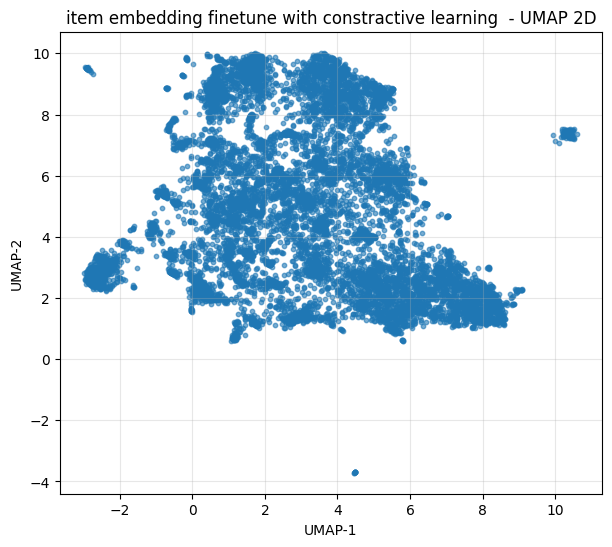

Visualization complete.


In [44]:
visualize_embeddings_2D(synopsis_content, "item embedding finetune with constractive learning ")

In [45]:
user_content = build_user_content(df_rating, synopsis_content)

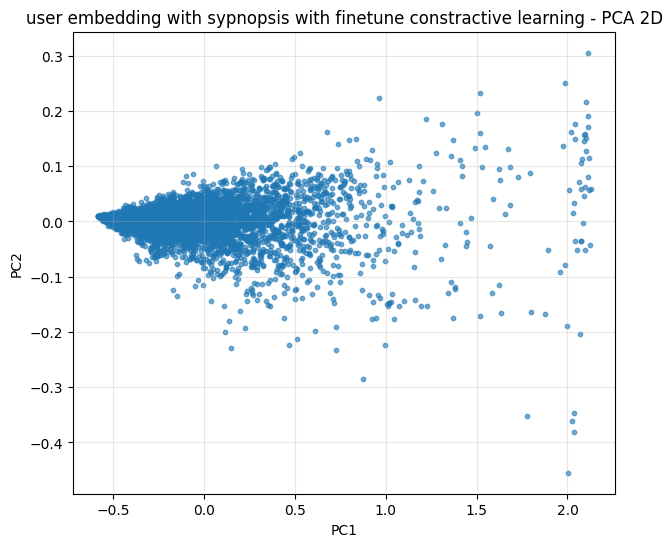

→ PCA explained variance ratio: [0.97823801 0.00955997]


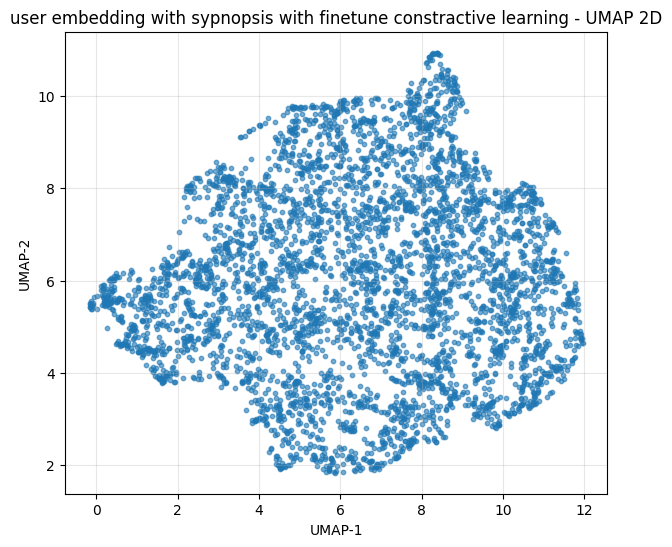

Visualization complete.


In [46]:
# user embedding visualize 
visualize_embeddings_2D(user_content, "user embedding with sypnopsis with finetune constractive learning")

In [47]:
# Evaluation similarity top K recommendation of content-based 

# train-test split build user content 
train_synopsis, test_synopsis = train_test_split(synopsis_content, test_size = 0.4, random_state = 42)
user_content_synopsis_eval = build_user_content(df_rating, test_synopsis)

for k in [10,20,40]:
    res = evaluate_content_based_topk(
        df_rating=df_rating,
        user_content_eval=user_content_synopsis_eval,
        test_items_df=test_synopsis,
        recommend_fn=recommend_topk_similarity,
        k=k,
        rating_threshold=7
    )
    
    print(res)


{'NDCG@10': np.float64(0.8078566162494026), 'Precision@10': 0.8054782218230929, 'MAP@10': 0.7154254157133627}
{'NDCG@20': np.float64(0.7952111752791281), 'Precision@20': 0.788609301280607, 'MAP@20': 0.6828129452496844}
{'NDCG@40': np.float64(0.7853335640872281), 'Precision@40': 0.778149606299212, 'MAP@40': 0.658552884129218}


**Inference**

In [48]:
def recommend_topk(user_id, df_content_user, df_item_embeddings, k=10):

    # ---- Lấy user vector ----
    user_vec = df_content_user.loc[df_content_user['user_id'] == user_id, 'embedding'].values[0]

    item_ids  = df_item_embeddings['anime_id'].values
    item_vecs = np.vstack(df_item_embeddings['embedding'].values)

    # ---- Tính cosine similarity ----
    scores = cosine_similarity([user_vec], item_vecs)[0]

    # ---- Lấy top-K ----
    top_idx = np.argsort(-scores)[:k]
    return item_ids[top_idx]

In [49]:
user_id = 326
top_anime = recommend_topk(user_id, user_content, synopsis_content, 10)
print(df_anime[df_anime['anime_id'].isin(top_anime)][['anime_id','Score','Genres','Name']])
print(df_rating[(df_rating['user_id'] == user_id) & (df_rating['anime_id'].isin(top_anime))])

       anime_id  Score                                             Genres  \
23           43   8.29  Action, Mecha, Police, Psychological, Sci-Fi, ...   
150         174   6.93  Action, Ecchi, Martial Arts, Comedy, Super Pow...   
415         457   8.69  Adventure, Slice of Life, Mystery, Historical,...   
4201       7724   7.79   Horror, Mystery, Supernatural, Thriller, Vampire   
5191      11433   7.49      Comedy, Drama, Romance, Sci-Fi, Slice of Life   
7827      31931   7.60                            Action, Mecha, Military   
8142      33031   7.08                                             Sports   
9468      37498   6.77                                             Action   
9728      38256   6.77              Psychological, Drama, Magic, Thriller   
10523     41619   7.33  Psychological, Shounen, Super Power, Supernatu...   

                                                    Name  
23                                      Koukaku Kidoutai  
150                               